<a href="https://colab.research.google.com/github/joubertt/dog-breeds/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Milestone Project 3**

*Dog Breed classification in Google Colab*



This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 & TensorFlow Hub

## 1. Problem
Identifying dog breed given the image of a dog.

## 2. Data
Data obtained from Kaggle dog breed identification problem: https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

For each image in the test set, you must predict a probability for each of the different breeds.
https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

##4. Features
* We're dealing with images, aka unstructured data, hence it's best to use deep learning/ transfer learning.
* There are 120 different dog breeds, hence 120 different classes.
* There are ~10,000 labelled images in the training set.
* There are ~10,000 images in the test set for which we must predict the labels.

**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Unzip data file**

In [2]:
# !unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog Vision/"

**Import the relevant libraries & get workspace ready**

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
print('TF Hub version:', hub.__version__)
print('TF version: ', tf.__version__)

# Check for GPU availability
print('GPU', 'available (YESS!!!)' if tf.config.list_physical_devices else 'not available :(')

TF Hub version: 0.12.0
TF version:  2.9.2
GPU available (YESS!!!)


**Getting our data ready**

Let's start by importing & exploring our data

In [4]:
import pandas as pd
labels_csv = pd.read_csv('/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/labels.csv')
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [5]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
# Determine how many images there are for each breed
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

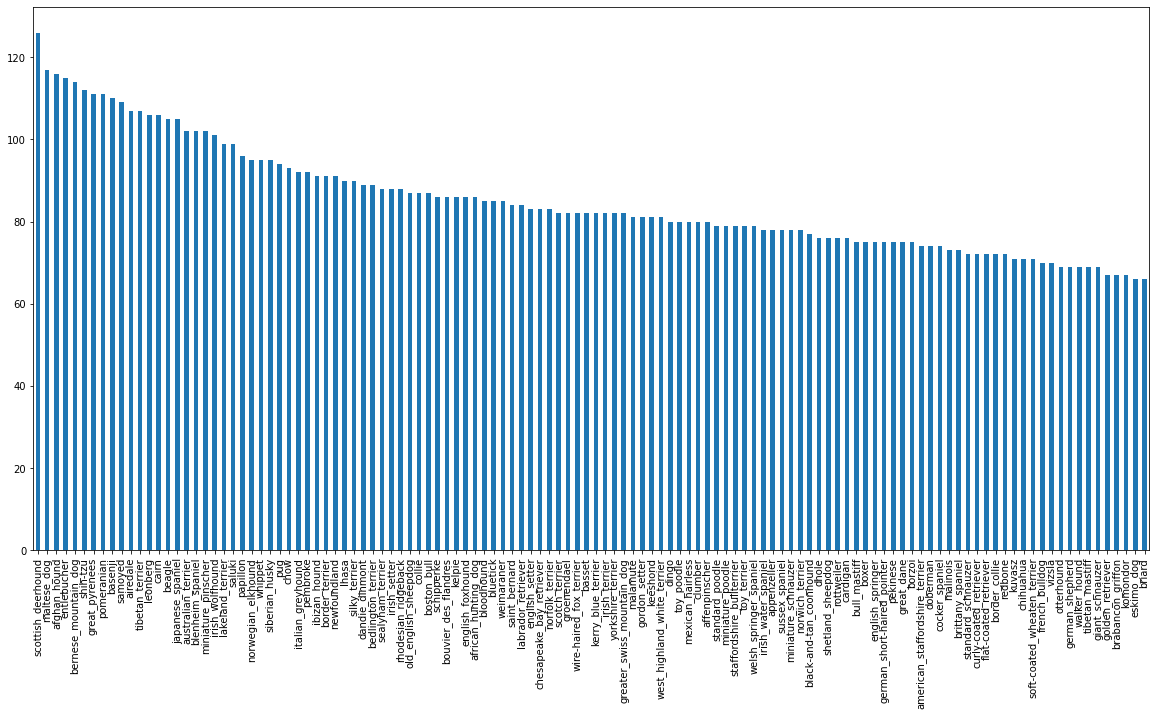

In [7]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

In [8]:
labels_csv['breed'].value_counts().median()

82.0

In [9]:
labels_csv['breed'].value_counts().min()

66

**Viewing images**

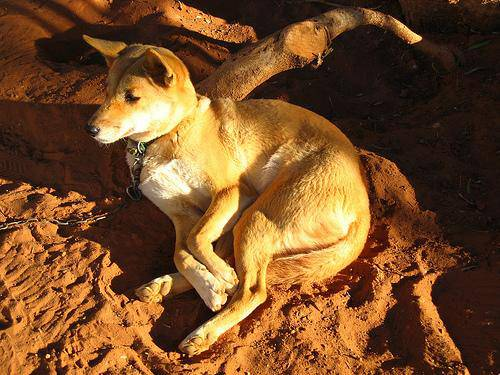

In [10]:
from IPython.display import Image
Image('/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

**Getting images & their labels**

Let's get a list of all our image file pathnames


In [11]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
# Create pathnames from image ID's
filenames = ['/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/'+ fname + '.jpg' for fname in labels_csv['id']]

# Check first 10 filenames
filenames[:10]

['/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/003d

In [13]:
# Check the actual number of image files in the train folder
import os

lst = os.listdir('/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train') # your directory path
number_files = len(lst)
print(number_files)

10206


In [14]:
# Check whether number of filenames are equal to actual image files
if len(os.listdir('/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train')) == len(filenames):
  print('Filenames match actual amount of image files')
else:
  print('Filenames do NOT match actual amount of image files')

Filenames do NOT match actual amount of image files


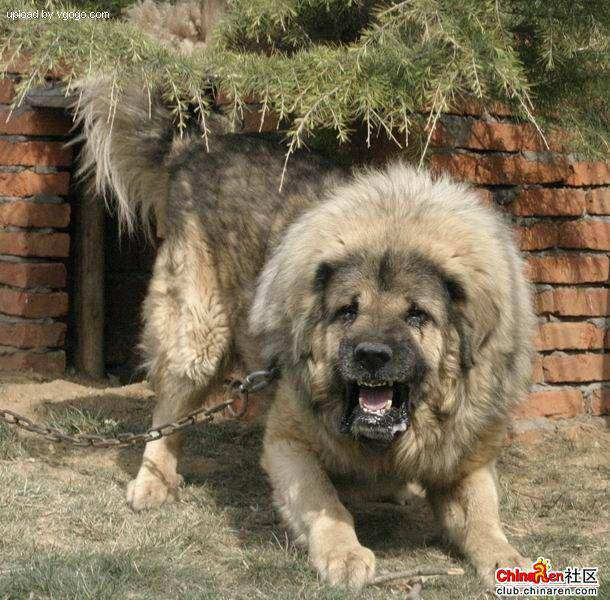

In [15]:
# One more check
Image(filenames[9000])

In [16]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels

In [17]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [18]:
len(labels)

10222

In [19]:
# Check for missing data again by checking if number of labels match number of filenames
if len(labels) == len(filenames):
  print('Number of labels matches number of filenames')
else:
  print('Oops, missing data')

Number of labels matches number of filenames


In [20]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [21]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds 

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [22]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
len(boolean_labels)

10222

In [24]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

This is done since Kaggle didn't provide us with one.


In [25]:
# Setup x and y variables
x = filenames
y = boolean_labels

In [26]:
# We're going to start off experimenting with ~1000 images & increase as needed

In [27]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:'slider', min:1000, max:10000, step:1000}

In [28]:
# Let's split our data into train & validation sets
from sklearn.model_selection import train_test_split

# Split them into training & validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

In [29]:
# Let's have a look at the training data
x_train[:5], y_train[:2]

(['/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification Unzipped/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

Preprocess images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TesnorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image` 

In [30]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """ 
  Takes an image file path and turns in into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn jpg into numerical Tensor with 3 colour channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

Turning data into batches

Why turn data into batches?
* To save memory
* We usually do about 32 images at a time

In order to use TensorFlow effectively, we need our data in the form of tuples which looks like this: `(image, label)`

In [31]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  process the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [32]:
# Demonstration of the above function
process_image(x[42]), tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all our data |(`x` and `y`) into batches

In [33]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batched
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data, but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test data set, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a validation dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))
    
    # Create (image, label) tuples (this also turns the image into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [34]:
# Creating training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [35]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [36]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

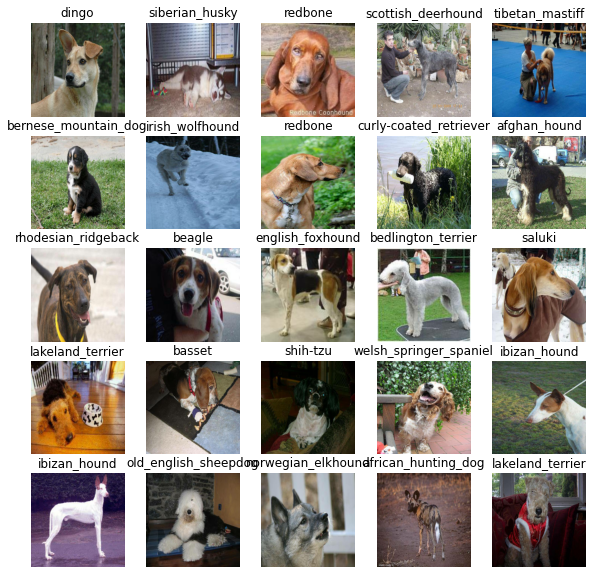

In [37]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

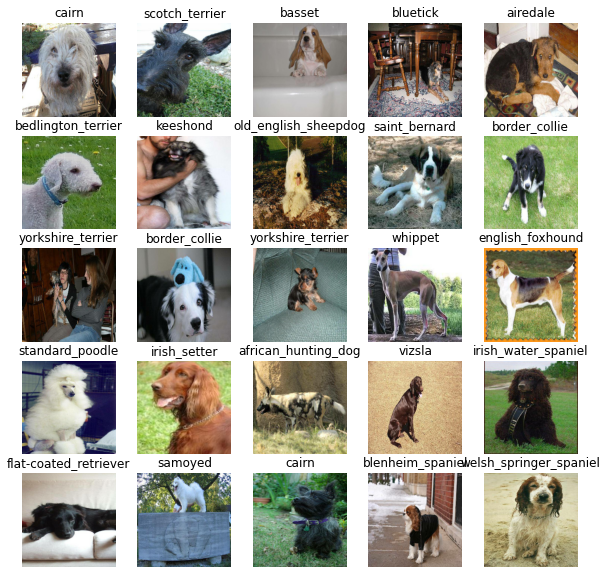

In [38]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
1. The input shape (our images shape, in the form of Tensors) to our model_selection
2. The output shape (image labels, in the form of Tensors) of our model.
3. The URL of the model we want to use (we're going to use an existing model and optimize it)

In [39]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE< IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TesnorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'

SyntaxError: ignored